In [1]:
import numpy as np
import pandas as pd
import aif360
import solas_disparity as sd

pd.set_option('display.max_columns', None)
np.random.seed(31415)

In [2]:
data = pd.read_parquet('hmda.parquet')
train = data.loc[data['train'] == 'train', :].copy().drop(columns=['train'])
valid = data.loc[data['train'] == 'valid', :].copy().drop(columns=['train'])
del data
display(train.sample(n=3, random_state=161803))
print(f"Number of Observations: Training: {train.shape[0]:,.0f}; Validation: {valid.shape[0]:,.0f}")
# train.groupby(label)['rate_spread'].agg(['min', 'max'])

,low_priced,interest_rate,rate_spread,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,state_target_encoded,product_type_conventional,product_type_fha,product_type_fsa_rhs,product_type_va,Black,Asian/PI,White,Native American,Hispanic,Non-Hispanic,Male,Female,Age >= 62,Age < 62,race,ethnicity,sex
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2695605,1.0,0.03875,0.00143,375000.0,0.95,1,0,395000.0,227000.0,0.33,1.0,1.0,0.090457,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown,Unknown,Unknown
4962145,1.0,0.03875,-0.00005,225000.0,1.00,1,0,225000.0,68000.0,0.33,1.0,1.0,0.043440,0,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,Black,Non-Hispanic,Male
4044205,1.0,0.04880,0.00886,275000.0,0.95,1,0,295000.0,144000.0,0.49,1.0,1.0,0.065950,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown


Number of Observations: Training: 240,510; Validation: 59,490


In [3]:
label = 'low_priced'
features = [
    'loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period', 'intro_rate_period',
    'property_value', 'income', 'debt_to_income_ratio', 'term_360', 'conforming',
    'state_target_encoded', 'product_type_conventional', 'product_type_fha',
    'product_type_fsa_rhs', 'product_type_va'
]

In [4]:
feature_to_label_corr = train[features].corrwith(other=train[label], method='spearman').sort_values()
monotonic_constraints = pd.Series(index=feature_to_label_corr.index, data=0)
monotonic_constraints[feature_to_label_corr >= 0.1] = 1
monotonic_constraints[feature_to_label_corr <= -0.1] = -1
print(monotonic_constraints)
monotonic_constraints = monotonic_constraints.to_dict()

product_type_fha            -1
loan_to_value_ratio         -1
debt_to_income_ratio        -1
state_target_encoded        -1
conforming                   0
term_360                     0
no_intro_rate_period         0
intro_rate_period            0
product_type_fsa_rhs         0
product_type_va              1
income                       1
loan_amount                  1
property_value               1
product_type_conventional    1
dtype: int64


In [5]:
# %%capture
import xgboost as xgb

params = {
    'n_estimators': 750,
    'eval_metric': 'auc',
    'random_state': 31415,
    'device': 'gpu',
    'tree_method': 'hist',
    'early_stopping_rounds': 10,
    'learning_rate': 0.05,
    'max_depth': 5,
    'monotone_constraints': monotonic_constraints,
}
eval_set = [(train[features], train[label]), (valid[features], valid[label])]


xgb_model = xgb.XGBClassifier(
    **params,
).fit(
    X=train[features], 
    y=train[label],
    eval_set=eval_set,
    verbose=100,
)
train['Prediction'] = xgb_model.predict_proba(X=train[features])[:, 1]
valid['Prediction'] = xgb_model.predict_proba(X=valid[features])[:, 1]


[0]	validation_0-auc:0.87450	validation_1-auc:0.87343
[100]	validation_0-auc:0.90053	validation_1-auc:0.90031
[200]	validation_0-auc:0.90344	validation_1-auc:0.90297
[284]	validation_0-auc:0.90388	validation_1-auc:0.90327


c:\Users\nickp\anaconda3\envs\cfpb_1\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:20:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [6]:
from sklearn import metrics

xgb_auc_train = metrics.roc_auc_score(y_true=train[label], y_score=train['Prediction'])
xgb_auc_valid = metrics.roc_auc_score(y_true=valid[label], y_score=valid['Prediction'])
print(
    f"\nTraining and Validation Set AUCs: {xgb_auc_train: 0.4f}, {xgb_auc_valid: 0.4f}"
    f"\nPercent Drop in AUC: Training to Validation: {xgb_auc_valid / xgb_auc_train -1:0.3%}"
)


Training and Validation Set AUCs:  0.9039,  0.9033
Percent Drop in AUC: Training to Validation: -0.064%


In [7]:
percent_offer = 0.6
offer_cutoff = train['Prediction'].quantile(1 - percent_offer)
train['Low-Priced Offer'] = train['Prediction'] > offer_cutoff
valid['Low-Priced Offer'] = valid['Prediction'] > offer_cutoff
print(valid['Low-Priced Offer'].value_counts(dropna=False, normalize=True))


True     0.600034
False    0.399966
Name: Low-Priced Offer, dtype: float64


In [8]:
# train_race_not_missing = train.loc[train['black'].notna(), :]
# valid_race_not_missing = valid.loc[valid['black'].notna(), :]
# print(f"Percent Reduction in Data Size Due to Missing Race: {len(train_race_not_missing) / len(train) - 1:0.1%}")


### Measuring Group Fairness Using `Aequitas`

Aequitas is a well-developed and maintained fairness auditing package developed by academics at the Center for Data Science and Public Policy and the University of Chicago.  Aequitas currently has three analytics classes, `Group()`, `Bias()`, and `Fairness()` that build upon each other to calculate confusion matrix-based metrics by group, and then create comparisons to a chosen reference group.  Aequitas also has a `Plotting()` class that leverages statistics calculated using the three analytics classes.  While Aequitas can be used to calculate many disparity metrics, we will focus on two: the Adverse Impact Ratio (Aequitas calls this the `Predicted Positive Rate Ratio`), and the relative `False Negative Rate`.  For descriptions of other metrics, readers should review Aequitas's documentation.

Aequitas can be downloaded using pip.  Note that as of the date of publication, installing Aequitas may cause some dependency errors when installing in the environment used in this book.  While we do not believe this causes any errors in results presented, one should proceed with caution.
```
pip install aequitas
```
Below the relevent Aequitas classes are imported and instantiated.

In [9]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

aeq_group = Group()
aeq_bias = Bias()
aeq_fairness = Fairness()
aeq_plot = Plot()


#### Aequitas Preprocessing  

Aequitas requires a dataframe with at least three columns that have set names to conduct a dispairty analysis. One column must contain the model's prediction or the model system's outcome (in our case, `Low Priced Offer`), and be called, `score`.  Another variable represents the true outcome (i.e., `low_priced`) and must be titled `label_value` within Aequitas. While the label must be binary, the `score` column can be either probabilities or binary outcomes.  The third required column contains the class data as a categorical value.  If there are multiple protected classes being analyzed, like race and sex, then more than one column can be provided.  Below, the necessary preprocessing is completed on the validity dataset.  In order to show how fairness can be calculated on multiple protected classes, both race and sex are considered. 

In [11]:
# aequitas_valid = valid[['sex', 'race', 'low_priced', 'predictions']].copy()
aequitas_valid = valid[['sex', 'race', label, 'Low-Priced Offer']].copy()
# aequitas_valid.loc[~aequitas_valid['race'].isin(['Black', 'White']), 'race'] = 'Other/Unknown'

aequitas_valid.rename(
    columns={
    'Low-Priced Offer': 'score',
    # 'predictions': 'score',
    label: 'label_value',
    },
    inplace=True
)
table_07 = aequitas_valid.sample(n=5, random_state=1618)
#  dfi.export(table_07, 'Table 07.png')
table_07


,sex,race,label_value,score
ID,,,,
5271564,Male,White,0.0,False
4204482,Male,Unknown,1.0,False
3927406,Unknown,White,1.0,True
4390283,Unknown,White,1.0,True
4390039,Unknown,Unknown,1.0,True


#### Calculating Group Fairness Metrics with Aequitas

Below, the three Aequitas analytics classes are run sequentially (`Group()` first, `Bias()` second, and `Fairness()` third).  If a user passes in the model's predictions rather than the outcome, in the `Group()` class the user has to include the `score_threshold` argument to provide thresholds for Aequitas to test.  Conveniently, Aequitas can test multiple cutoffs and ways to create cutoffs (e.g., score thresholds or rank thresholds).  A disadvantage to using thresholds is that, as of the time of publication, Aequitas errors out in the `Bias()` class if the user specifies that they want to test statistical significance, but has provided threshold-based outcomes.   However, since we are using the binarized `Low Priced Offer` outcome, we are able to calculate statistical significance.

In [12]:
crosstabs, _ = aeq_group.get_crosstabs(
    df=aequitas_valid,
    attr_cols=['sex', 'race'],
)
bias_report = aeq_bias.get_disparity_predefined_groups(
    df=crosstabs,
    original_df=aequitas_valid,
    ref_groups_dict={'race': 'White', 'sex': 'Male'},
    check_significance=True,
    alpha=0.05,
    mask_significance=False,
)

In the `Bias()` call above, the `alpha` parameter is the value of the two-sided p-value used to measure whether a result is statistically significant.  As is standard, a 5% test is used here.

In [13]:
fairness_report = aeq_fairness.get_group_value_fairness(
    bias_df=bias_report,
    tau=0.95,  # Note high value
)

The `Fairness().get_group_value_fairness()` call uses an argument, `tau`, which is the threshold used for practical significance.  Only one threshold value of `tau` can be provided, which means that threshold is applied across all of the metrics calculated.  This is problematic because it is unlikely that it makes sense for a single threshold value has meaning across a broad range of metrics.  If the reader is using Aequitas to measure fairness across multiple metrics, instead of using the `tau` argument, it may make more sense to set metrics individually and determine significance programmatically (i.e., write one's own code for determining significance, rather than using Aequitas's method).

Here, we set the `tau` threshold to 0.95, rather than 0.80 (which is the default value and what we used in the code above).  In practice, this would generally be a higher threshold than is typically used.  We set it this high so that we can better demonstrate Aequitas's usage of the threshold. 

In [14]:
fairness_columns = ['attribute_value',  'fnr', 'fnr_significance', 'fnr_disparity',  
    'FNR Parity', 'pprev', 'pprev_disparity', 'pprev_significance', 'Impact Parity']

race_values = valid['race'].unique()   
fairness_mask = fairness_report['attribute_value'].isin(race_values)
format_dict = {key: '{:0.1%}' for key in ['fnr', 'fnr_significance', 'pprev', 'pprev_significance']}
format_dict = {**format_dict, **{key: '{:0.3f}' for key in ['fnr_disparity', 'pprev_disparity']}}
table_08 = fairness_report.loc[fairness_mask, fairness_columns].style.format(format_dict).hide(axis='index')
# dfi.export(table_08, 'Table 08.png')
table_08

attribute_value,fnr,fnr_significance,fnr_disparity,FNR Parity,pprev,pprev_disparity,pprev_significance,Impact Parity
Unknown,27.5%,4.3%,0.722,False,67.3%,1.199,0.0%,False
Asian/PI,21.0%,2.8%,0.611,False,75.4%,1.253,0.0%,False
Black,55.2%,0.0%,1.607,False,36.3%,0.604,0.0%,False
Native American,48.2%,95.3%,1.404,False,45.8%,0.762,0.0%,False
Unknown,30.8%,4.3%,0.896,False,63.4%,1.054,0.0%,False
White,34.4%,100.0%,1.000,True,60.1%,1.000,100.0%,True


While Aequitas has calculated many metrics via `get_group_value_fairness()`, we report those for the adverse impact ratio (identified as the columns containing `pprev` and `Impact Parity`) and the false negative rate ratio (identified as columns that begin with `fnr`).  As expected, the results for the AIR, `pprev_disparity`, are the same as those found in our calculations above.  The measures of statistical significance for the AIRs, `pprev_significance`, are slightly, but not meaningfully, different because Aequitas uses a t-test to test statistical significance, rather than a logistic regression.  

It is important to note that the parity columns (`FNR Parity` and `Impact Parity`) only incorporate thresholds, and they do not consider statistical significance.  In the results above, we see that Aequitas reports that the test of parity failed for Hawaiian or Pacific Islander group even though the p-value, `pprev_significance` is greater than our threshold of 5%.  For this reason, one would generally not want to use the parity columns on their own from Aequitas, but also incorporate information from the significance columns. 

Another important consideration is that Aequitas's `tau` parameter is transformed such that any value below `tau` or any value above `1 / tau` is considered practically significant.  Using our threshold of 0.95, this means that `Parity = (0.95 <= X <= 1.053)`.  This is why we see the `Impact Parity` column being `False` for Asians: the AIR of 1.099 exceeds the inverse value of tau, `1 / 0.95 ≈ 1.053`.  Whether a result that significantly favors a protected class is meaningful depends heavily on context and usage.  In many cases, this is of less concern.  However, the use of the inverse value is helpful because a lower value of some metrics is more favorable than a higher value.  We can see this in a comparison between the adverse impact ratio and the relative false negative rate results above.  While a result below 1.0 indicates disfavorable outcomes for a protected group for adverse impact ratios, a value above 1.0 indicates disfavorable outcomes for protected groups for relative false negative rates.  Here, a false negative is a bad outcome: the borrower does not receive a low-priced loan when they would have otherwise.  Using the results above, we see that Black or African-American borrowers were 2.23 times as likely not to receive a low-priced loan under this model relative to White borrowers.  This greatly exceeds our threshold of approximately 1.053.  Given that it is also statistically significant (`fnr_significance` < 0.05), a user considering the relative false negative rate results would flag this for subsequent review and analysis.


### Plotting with Aequitas

Aequitas has a number of helpful and plots that allow users to display information about the results found in the analytics classes.  Most of these plots are available through the `Plot()` class, though several have to be accessed via `aequitas.plot`.  The first two plots below are `matplotlib`-based plots, created with the `Plot()` class.  There are a number of variations that highlight different characteristics, such as whether results are statistically significant, or have different color patterns. Useful arguments include `min_group_size`, which limits plotting to groups that represent at least a specified percent of the population.

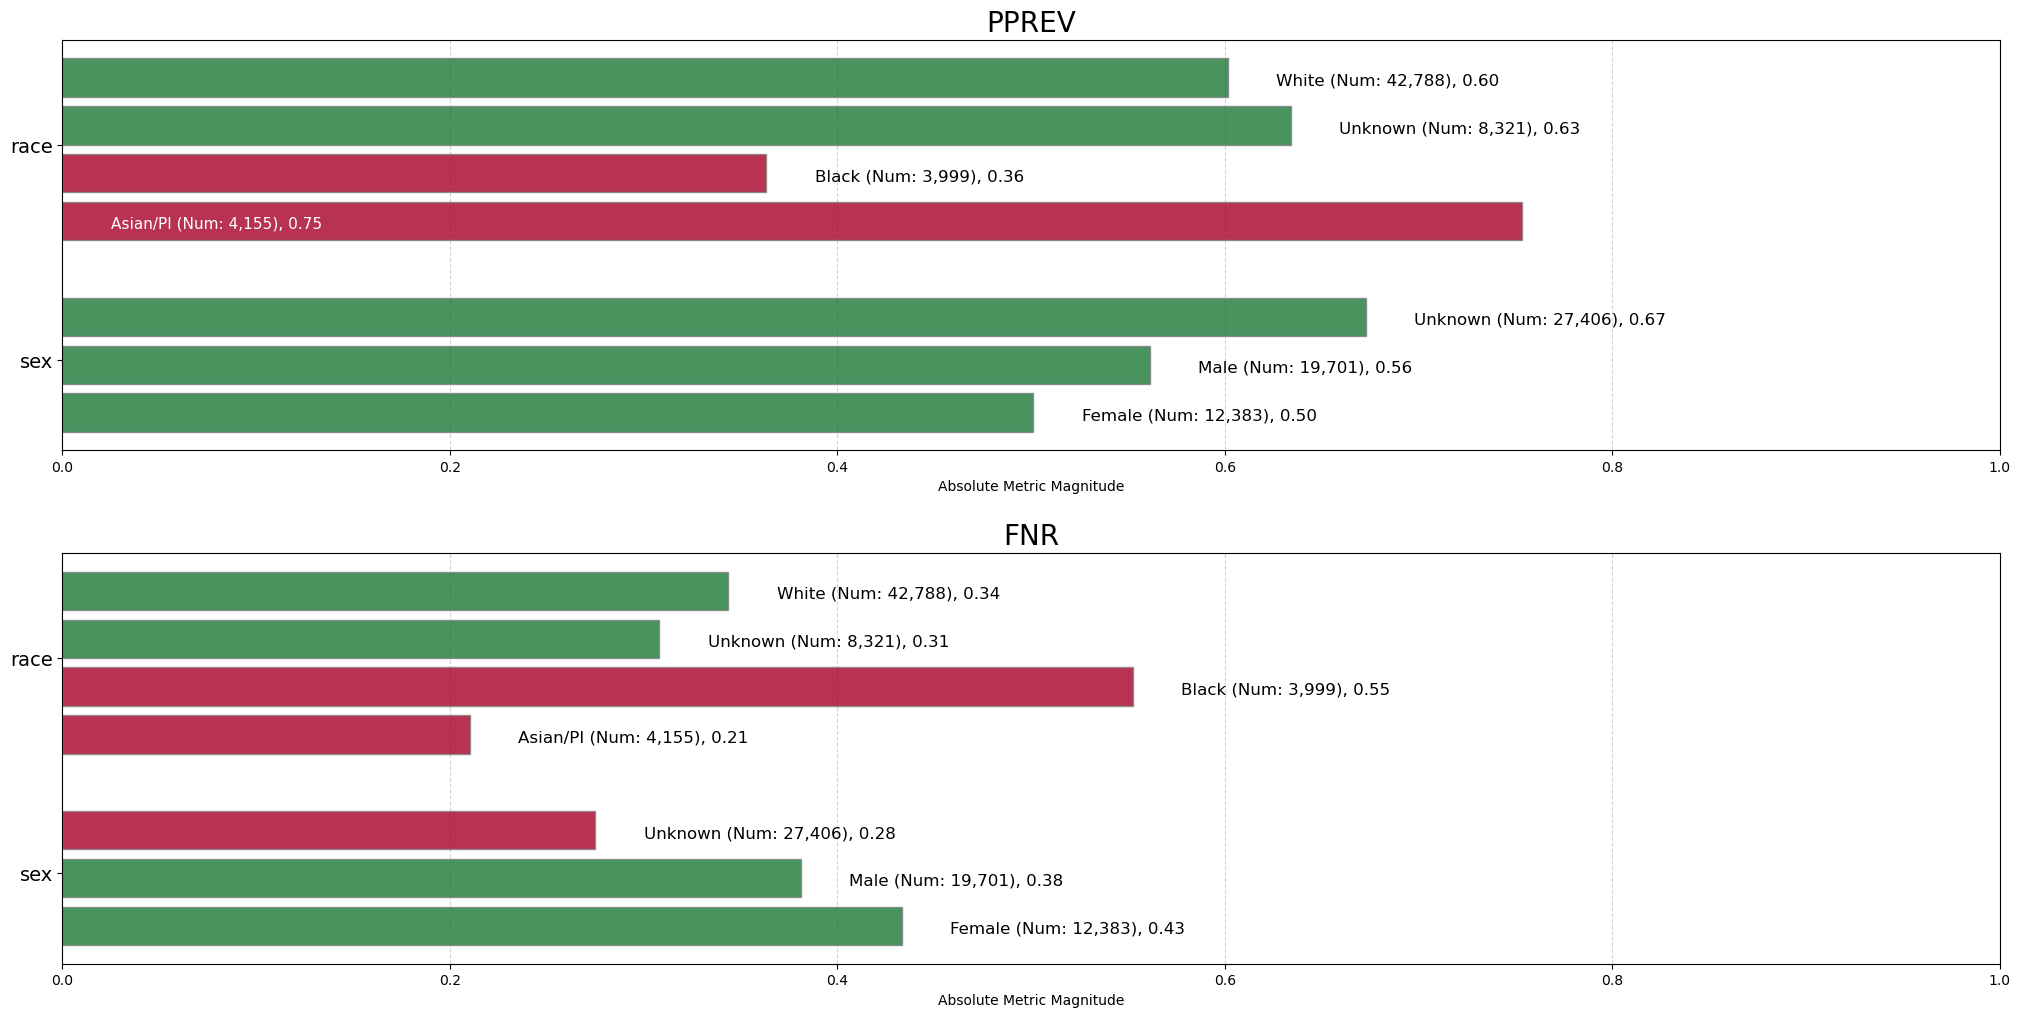

<Figure size 640x480 with 0 Axes>

In [15]:
fairness_report_tau_80 = aeq_fairness.get_group_value_fairness(
    bias_df=bias_report,
    tau=0.80,
)
_ = aeq_plot.plot_fairness_group_all(
    fairness_table=fairness_report_tau_80,
    ncols=1, 
    metrics=['pprev', 'fnr'],
    min_group_size=0.01,
)

Before creating the plots, we recalculate `Fairness().get_group_value_fairness()`, using a more reasonable `tau=0.80`.  The PPRV results display the percent of each class that recieved a favorable outcome.  For example, Black applicants received a favorable outcome 63% of the itme, but White applicants received a favorable outcome 83% of the time.  This contrast is revealed through the relative length of the bars.  The red bars indicate results for groups outside of the `tau` or `1 / tau` threshold.  Importantly, this coloring does not take into account statistical significance.  As an alternative to this plot, one can use `Plot().plot_group_metric_all()` to plot the same information without the threshold-based color mapping.

The next plot shows the disparity metrics by race.  The size of each box represents the relative size of each group while the color scale represents the level of disparity.  We can use these plots by looking for cells with more extreme colors to identify where there are larger disparities (e.g., most clearly, Black applicants for FNR disparity).  We can also use the sizes of the boxes to understand whether the disparities occur for groups that represent a substantial portion of the population.  This helps a user to quickly identify major areas of concern.  A further advantage of this plot is that it shows whether a disparity is statistically significant.  If it is, then two asteriks appear after the value for the disparity metric (e.g., "0.76**" for Black applicants).  An important note of caution is that, if a large number of groups are plotted, then the disparity values and their statistical significance may not be displayed.  In this case, one could easily misinterpret the plot by assuming that the results are not statistically significant.  Another version of this plot can be called using `Plot().plot_fairness_disparity_all`.  This version uses a red/green color mapping to show levels of practical significance, similar to the first plot above.

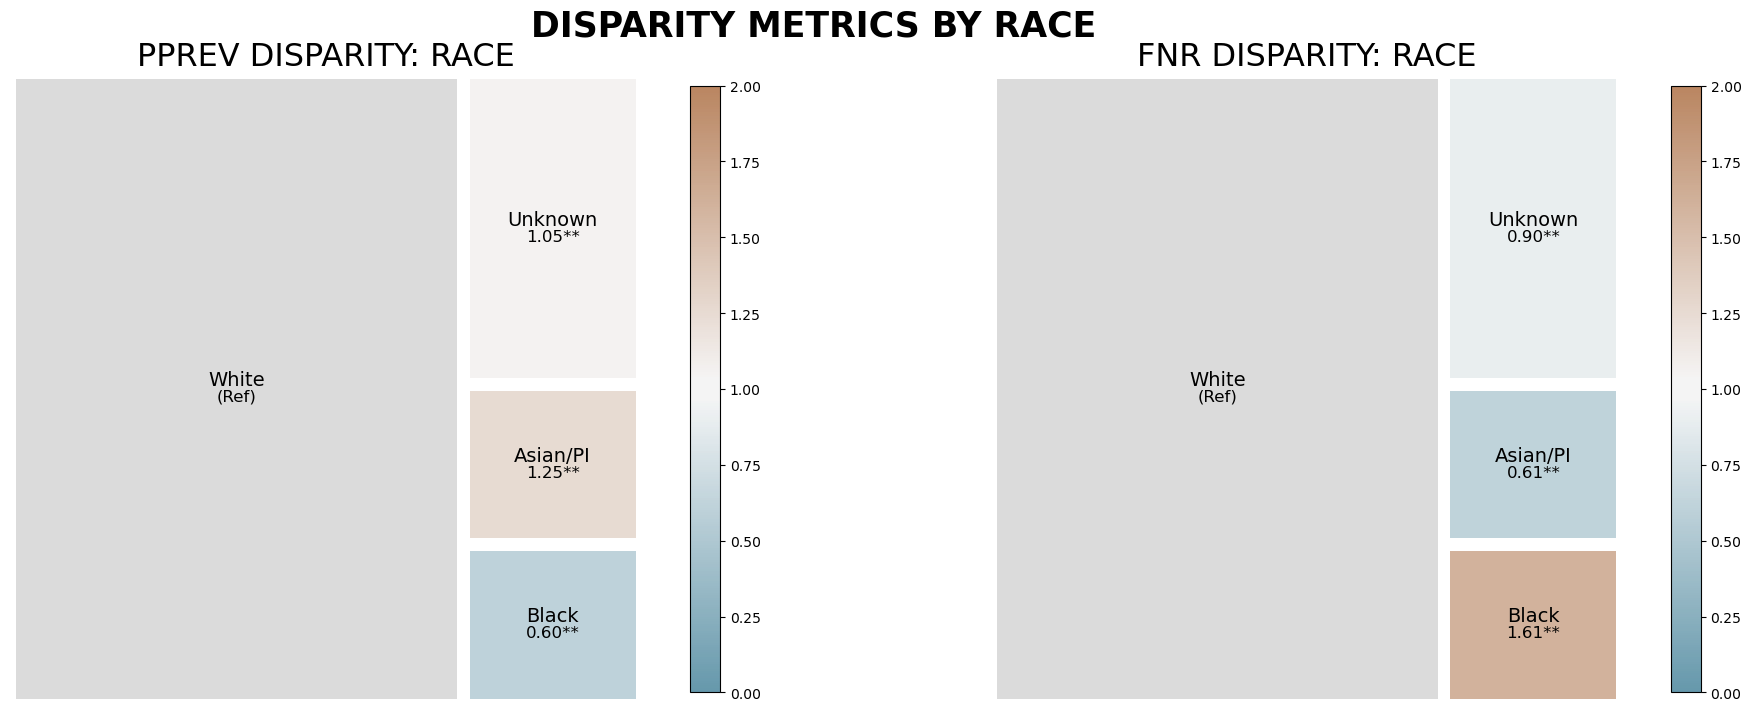

In [16]:
_ = aeq_plot.plot_disparity_all(
    data_table=fairness_report_tau_80,
    attributes=['race'],
    metrics=['pprev', 'fnr'],
    min_group_size=0.01,
    significance_alpha=0.05,
)

The subsequent disparity plot is generated via `aequitas.plot`.  For users creating interactive reports, plots using `aequitas.plot` do allow the user to highlight and remove information about particiular classes as well as get information by hovering over particular groups.  As can be seen in the code and charts, there is an inconsistency in the specification of the threshold metric.  In the other plots, it was called as the argument `tau` and forced to be below 1.0. In these charts, the argument is `fairness_threshold` and is set as `1 / tau`.  This can easily create confusion, but Aequitas does error out if a user tries to send in a value greater than 1.0.  An additional source of confusion can occur for users when printing two statistics like these on the same chart.  As discussed above, a lower value represents harm for a protected group for PPREV, but a higher value for FNR for a protected group.  It is easy for a user to miss this information.  One should be careful about noting this discrepency or results could eaisly be misinterpreted.  One simple solution is to split the printing into two separate charts with notes explaining how to interpret them.

In [17]:
import aequitas.plot as ap

ap.disparity(
    disparity_df=bias_report,
    metrics_list=['pprev', 'fnr'],
    attribute='race',
    fairness_threshold=5/4,
)

c:\Users\nickp\anaconda3\envs\cfpb_1\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\nickp\anaconda3\envs\cfpb_1\Lib\site-packages\altair\vegalite\v5\api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\Users\nickp\anaconda3\envs\cfpb_1\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\nickp\anaconda3\envs\cfpb_1\Lib\site-packages\altair\vegalite\v5\api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\Users\nickp\anaconda3\envs\cfpb_1\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.w

alt.LayerChart(...)

### Measuring Group Fairness with AI Fairness 360

We next show how to calculate several group fairness metrics using IBM's AI Fairness 360 Toolkit ("AIF 360").  While there are many similarities across Aequitas and AIF 360, each package has its own set of features that make it valuable.  Aequitas's simultanious creation of many metrics is advantageous in a situation where a user will want to create a report comparing metrics.  Its graphing functionality (subject to the caveats listed above) also makes it a lower-code way to create and display information on fairness.  On the other hand, AIF 360 has significant additional functionality in the form of a robust selection of pre-processing, in-processing, and post-processing algorithms that help to mitigate disparities. These methods will be discussed in later chapters.  As is shown in the last example below, it also has the ability to make arbitrary fairness metrics following the `sklearn.metric` API structure.  

Being able to try to mitigate any fairness problems found is a crucial step in any robust AI pipeline.  Given the algorithms that perform this that are available in AIF 360's package, it is important for the user to understand how to prepare data and test it using the AIF 360 fairness metric functionality.  


#### Preparing Data for use in AIF 360

In order to use AIF 360's metrics, we need to create a pandas frame that has no missing values for group status, and set an index equal to dummy variables (i.e., 0's or 1's) that indicate membership in a class.  Unfortunately, if there is more than one class in a group characteristic, such as the multiple values possible for race, AIF 360 can only run one class comparison at a time.  Becaus of this, below only Black or African American applicants will be compared to White applicants.  While it is further worth noting that multiple groups (e.g., race and sex) can be setup to be assessed at the same time, if missing values for these different groups do not align then the results will not be correct.

Somewhat confusingly relative to other packages, when setting up the data, one will want to set the dummy variable for the reference group as the index value to be assessed.  Not doing this will lead the results to be the exact opposite of what is intended.  In the case of the adverse impact ratio, if one weere to pass `black` into the index and run the metrics, then the resulting fairness metric would be the inverse of the correct metric.  Not realizing this might lead one to assume there are favorable outcomes for a protected group, rather than unfavorable outcomes.

In [22]:
aif_valid = valid.loc[(valid['Black'] + valid['White'] == 1), :]
aif_valid = aif_valid.set_index(keys=['White'], append=True, drop=False)

AIF 360 has two ways to calculate fairness metrics.  One is through a native API call, `aif360.metrics`, the other is through a `scikit-learn` style API.  Below, the adverse impact ratio, which AIF 360 refers to as the "Disparate Impact Ratio" is called using the `sklearn.metric` functionality.  As expected, the results are identical to what was achieved above using both the hand-written code as well as the Aequitas-based code.

In [23]:
from aif360.sklearn import metrics as aif_metrics

aif_adverse_impact_ratio = aif_metrics.disparate_impact_ratio(
    aif_valid['Low-Priced Offer'], 
    prot_attr=['White'],
)
print(f"Adverse Impact Ratio (AIR): {aif_adverse_impact_ratio:0.3%}")

pip install 'aif360[inFairness]'
pip install 'aif360[OptimalTransport]'


Adverse Impact Ratio (AIR): 60.415%


Fairness metrics can typically be categorized as ones that are based on differences in metrics between protected and reference classes (e.g., marginal effects and SMD), and those that are based on ratios of protected to reference classes (e.g., AIRs and false negative rate ratios).  Helpfully, AIF 360 has generic functions that can calculate differences or ratios of any AIF 360 or standard scikit-learn metric.  These can be accessed via `metrics.difference` and `metrics.ratio` from `aif360.sklearn`.  This functionality can be particularly helpful if a user wants to test disparities for a novel metric that has not been coded into AIF 360 or Aequitas.  The code below calculates the false negative rate ratio by calling AIF 360's false negative rate function.  As expected, the results match those calculated using Aequitas.

In [24]:
aif_fnr = aif_metrics.ratio(
    aif_metrics.false_negative_rate_error, 
    aif_valid[label], 
    aif_valid['Low-Priced Offer'], 
    prot_attr='White',
)
print(
    f"False Negative Rate Ratio: {aif_fnr:0.3f}"
)

False Negative Rate Ratio: 1.607


Although a relative ROC-AUC score would likely not be considered a group fairness metric by most practioners, below the code required to calculate this metric is presented in order to show how one can implement an arbitrary scikit-learn metric utilizing AIF 360.

In [26]:
from sklearn import metrics as sklearn_metrics

relative_auc_ratio = aif_metrics.ratio(
    sklearn_metrics.roc_auc_score, 
    aif_valid[label], 
    aif_valid['Prediction'], 
    prot_attr='White',
)
print(f"Relative ROC-AUC Scores for Blacks and Whites: {relative_auc_ratio:0.3f}")

Relative ROC-AUC Scores for Blacks and Whites: 0.932


### Measuring Group Fairness with SolasAI

Of the three packages discussed in this chapter, `SolasAI` is the most complete in terms of being able to combine all of the concepts discussed above with minimal additional effort.  The package can run most commonly used measures of group fairness, including the AIR and SMD, calculate various confusion-matrix based statistics such as relative false positive and false negative rates, and also allows for a user-defined function. In addition to calculating the metrics, SolasAI also automatically calculates statistical and practical significance.  It further provides charting and customization that allow the user to set variable and chart names, so that it can easily be used in production across use cases. SolasAI also handles proportional estimation of class status, which means that it can be used with probability estimates of class membership, rather than just with binary outcomes. Finally, SolasAI also handles missing values internally, so you don't have to subset dataframes for rows where there is missing class information. SolasAI is available via the standard pypi repository, and can be downloaded with pip:

```pip install solas-ai```

#### Preprocessing Data for SolasAI

Preprocessing data for SolasAI is fairly straightforward.  However, unlike the other packages, SolasAI requires each class to be represented by its own variable.  For example, if we are analyzing race differences for Blacks, Asians, and Whites, and Other Races, four variables would be required: one for Black, one for Asian, one for white, and one for Other Races. The values of these variables can be binary 0/1, boolean, or, if class status is proportional, the variables can be probability estimates of class membership.

Below, we create the variables used by SolasAI to measure disparities.  First, we calculate the counts by ethnicity and race.  After that, we create the 0/1 variables that identify particular classes.  Notice that we do not code all possible combinations: for ethnicity, we do not code "Unknown."  For race, we only encode Black, Asian, and white.  We do this here to highlight the fact that there are times when a user will only want to review certain comparisons and SolasAI can automatically handle these types of comparisons. For example, in practice, observations that do not have an identified group status (that is, those that are classified as "Unknown" here) are rarely analyzed or included in any reporting. 

In [27]:
print(f"{valid['ethnicity'].value_counts()}")
print(f"\n{valid['race'].value_counts()}")

Non-Hispanic    44966
Unknown          8306
Hispanic         6218
Name: ethnicity, dtype: int64

White              42788
Unknown             8321
Asian/PI            4155
Black               3999
Native American      227
Name: race, dtype: int64


The code below creates the 0/1 categorical variables. If we wanted to get categorical variables for all possible values, this can be done easily with the `pd.get_dummies()` function. After we create the variables, we test that the coding was done properly by summing the new columns and comparing the totals to the counts above.  Here, we see that all of the values encoded have the same sums and counts, so we can assume that the encoding was successful.

In [ ]:
# valid.loc[valid['ethnicity'] == 'Hispanic', 'hispanic'] = 1
# valid.loc[valid['ethnicity'] == 'Non-Hispanic', 'hispanic'] = 0
# valid['non-hispanic'] = 1 - valid['hispanic']

# valid.loc[valid['race'] == 'Black', 'Black'] = 1
# valid.loc[valid['race'] == 'Asian', 'Asian'] = 1
# valid.loc[valid['race'] == 'White', 'White'] = 1
# valid.loc[valid['race'].isin(['Black', 'Asian']), 'White'] = 0
# valid.loc[valid['race'].isin(['Black', 'White']), 'Asian'] = 0
# valid.loc[valid['race'].isin(['White', 'Asian']), 'Black'] = 0

# print(f"{valid[['hispanic', 'non-hispanic', 'Black', 'White', 'Asian']].sum()}")



#### Calculating Group Fairness with SolasAI

The first metric we calculate is the adverse impact ratio. To do this in SolasAI, one specifies lists of `protected_groups`, `reference_groups`, and `group_categories`. Each element of these three lists corresponds to a specific comparison. Using the code below, the first element in the three lists are "Black", "White", and "Race".  This means that we are going to compare Blacks to Whites, and that comparison is along the dimensions of race.  The second element of each list compares "Asian" to "White". We see that it is also a comparison of "Race". Finally, the third elements of the three lists are "female", "male", and "Gender". This means we are performing a comparison of "Gender" where we assess whether there are disparities for women relative to men. The data where the protected and reference group information is located is sent into the `group_data` argument. Here, we are analyzing data in the validation dataset, so we set `group_data=valid`. In SolasAI, the variable that is being analyzed is called the `outcome` variable. Since the calculation of the AIR requires a binary outcome, we set outcome equal to the validation set's `Low Priced Offer` variable. Importantly, for the SolasAI AIR function, it is assumed that `outcome=1` is favorable and `outcome=0` is unfavorable. 

Finally, we specify two measures of practical significance for the AIR. The first is the AIR threshold, which was discussed above. Here, any AIR that falls below the set value (in this case, 0.80) would be considered practically significant if it is also statistically significant. Second, we set a `percent_difference_threshold`, which says that a result cannot be practically significant unless the raw average difference exceeds a set value. For example, suppose we set `percent_difference_threshold=0.05` and `air_threshold=0.80`. Further suppose that 10% of white applicants receve an offer, but only 7% of Black applicants receive an offer. The AIR here is 0.70, which would be significant under the air threshold value of 0.80. However, the 3% raw difference in offer rates (3% = 10% - 7%) is less than the percent difference threshold of 0.05. Because of this, this result would not be considered practically significant. In our experience, it is relatively rare for users to specify a percent difference threshold, so in our code we set that to zero, which means that it will never be binding.

While the user sets the practical significance thresholds, SolasAI automatically calculates and determines statistical significance. This is done using a two-tailed 5% test (or, equivilently, a one-tailed 2.5% test). In the AIR calculation, if there are few people in the comparison, then statistical significance is calculated using a Fisher's exact test. When there are a large number of people in the dataset, then a chi-squared test is used.

In [30]:
protected_groups = ['Black', 'Asian/PI', 'Native American', 'Hispanic', 'Female']
reference_groups = ['White'] * 3 + ['Non-Hispanic', 'Male']
group_categories = ['Race'] * 3 + ['Ethnicity', 'Sex']

In [31]:
import solas_disparity as sd

In [32]:
solas_air = sd.adverse_impact_ratio(
    group_data=valid,
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=valid['Low-Priced Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0,
)
solas_air

## Disparity Calculation: Adverse Impact Ratio

┌─────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────┐
│ Protected Groups                        │ Black, Asian/PI, Native American, Hispanic, Female                    │
│ Reference Groups                        │ White, White, White, Non-Hispanic, Male                               │
│ Group Categories                        │ Race, Race, Race, Ethnicity, Sex                                      │
│ AIR Threshold                           │ 0.8                                                                   │
│ Percent Difference Threshold            │ 0.0                                                                   │
│ Shortfall Method                        │ to_reference_mean                                                     │
│ Affected Groups                         │ Black, Native American, Hispanic                                      │
│ Affected Reference                      │ White, White, Non-Hispanic                                            │
│ Affected Categories                     │ Race, Race, Ethnicity                                                 │
└─────────────────────────────────────────┴───────────────────────────────────────────────────────────────────────┘

## Adverse Impact Ratio Summary Table

\* Percent Missing: Ethnicity: 13.96%, Race: 13.99%, Sex: 46.07%

Group,Reference Group,Group Category,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Black,White,Race,"3,999.0","1,453.0",36.33%,23.81%,0.604,0.000,Yes,952.0
Asian/PI,White,Race,"4,155.0","3,131.0",75.35%,-15.21%,1.253,0.000,No,
Native American,White,Race,227.0,104.0,45.81%,14.33%,0.762,0.000,Yes,32.5
White,,Race,"42,788.0","25,733.0",60.14%,,,,,
Hispanic,Non-Hispanic,Ethnicity,"6,218.0","2,256.0",36.28%,26.39%,0.579,0.000,Yes,"1,641.2"
Non-Hispanic,,Ethnicity,"44,966.0","28,183.0",62.68%,,,,,
Female,Male,Sex,"12,383.0","6,206.0",50.12%,6.00%,0.893,0.000,No,
Male,,Sex,"19,701.0","11,055.0",56.11%,,,,,


We can use the `solas_air` disparity object we create above to generate output tables and plots of results. The heart of the SolasAI disparity object is the `summary_table`, which we display below. This can be displayed directly, or, if the user wants formatted output, we can display it using the SolasAI user interface functionality `solas_disparity.ui.show()`. Below, we display the formatted results.

In [ ]:
sd.ui.show(solas_air.summary_table)

We can also plot the output of the disparity results using a `.plot()` function. If the user does not specify the column to plot then the disparity metric (here, the AIR) automatically gets plotted. If the results are practically significant then the value is plotted with crosshatching, as occurs here for Black applicants.

In [ ]:
solas_air.plot()

To plot a specific column, one uses the `column` argument in the plot function. Here, we plot the column of total observations. The reference group for each comparison is plotted with a border around it.

In [ ]:
solas_air.plot(column='Total')

Next, we calculate and display the summary table for the standardized mean difference. The call for the SMD is similar to that for the Adverse Impact Ratio, but with `smd_threshold` replacing `air_threshold`. At the time of writing, the SMD call does not include a threshold like the `percent_difference_threshold` in the adverse impact ratio call. In this call, we add the label variable, `valid['low_priced']`. This is not used in computations of the SMD, but is displayed in the summary table and can be printed. Including the label is possible in all of the SolasAI functions. 

Before we call the SMD, we change two constant values, the `AVERAGE_OUTCOME` and `AVERAGE_LABEL`. Doing this allows customization of the output summary table and charts. This gives the user the ability to be more specific for the particular use case. As an example, we changed "Average Label" to now read "Percent Low-Priced".

In [ ]:
sd.const.AVERAGE_OUTCOME = 'Average Prediction'  # Was Average Outcome
sd.const.AVERAGE_LABEL = 'Percent Low-Priced'  # was Average Label

solas_smd = sd.standardized_mean_difference(
    group_data=valid,
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=valid['Prediction'],
    label=valid['low_priced'],
    smd_threshold=-30,
    lower_score_favorable=False,
)

In [ ]:
sd.ui.show(solas_smd.summary_table.drop(columns=['Std. Dev. of Outcomes', 'Percent Missing']))

The code below changes the title of the SMD plot to be more specific to the particular use case.

In [ ]:
sd.const.SMD_SMD_PLOT_TITLE = "Standardized Mean Difference of Low-Priced Predictions"
solas_smd.plot()

In [33]:
solas_auc = sd.custom_disparity_metric(
    group_data=valid,
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=valid['Prediction'],
    label=valid[label],
    metric=metrics.roc_auc_score,
    ratio_threshold=lambda x: x < 1.0,
    difference_threshold=lambda x: x > 0.01,
)
solas_auc

## Disparity Calculation: Custom Disparity Metric

┌────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                   │ Black, Asian/PI, Native American, Hispanic, Female                         │
│ Reference Groups                   │ White, White, White, Non-Hispanic, Male                                    │
│ Group Categories                   │ Race, Race, Race, Ethnicity, Sex                                           │
│ Metric                             │ roc_auc_score                                                              │
│ Difference Calculation             │ reference_minus_protected                                                  │
│ Ratio Calculation                  │ protected_over_reference                                                   │
│ Affected Groups                    │ Black, Native American, Hispanic                                           │
│ Affected Reference                 │ White, White, Non-Hispanic                                                 │
│ Affected Categories                │ Race, Race, Ethnicity                                                      │
└────────────────────────────────────┴────────────────────────────────────────────────────────────────────────────┘

## Custom Disparity Metric Summary Table

\* Percent Missing: Ethnicity: 13.96%, Race: 13.99%, Sex: 46.07%

Group,Reference Group,Group Category,Total,Total Label,Average Label,ROC AUC SCORE,Difference,Ratio,Practically Significant
Black,White,Race,"3,999.0","3,182.0",0.80,0.839784,0.062,0.932,Yes
Asian/PI,White,Race,"4,155.0","3,950.0",0.95,0.942627,-0.041,1.046,No
Native American,White,Race,227.0,199.0,0.88,0.781497,0.120,0.867,Yes
White,,Race,"42,788.0","38,840.0",0.91,0.901385,,,
Hispanic,Non-Hispanic,Ethnicity,"6,218.0","4,876.0",0.78,0.850747,0.054,0.941,Yes
Non-Hispanic,,Ethnicity,"44,966.0","41,302.0",0.92,0.904364,,,
Female,Male,Sex,"12,383.0","10,831.0",0.87,0.886625,0.007,0.992,No
Male,,Sex,"19,701.0","17,664.0",0.90,0.893412,,,


In [ ]:
print(f"AIF360 Relative AUC Calculation for Black-White: {relative_auc_ratio:0.3f}")